In [405]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline
from scipy.optimize import fsolve
from tqdm.notebook import tqdm
from glob import glob

In [1324]:
def read_files(path):
    waveforms = []
    baselines = []
    led = []

    for f in glob(path):
        waveform = np.loadtxt(f, delimiter=",", skiprows=16)
        baseline = np.mean(waveform[:100][:,1])
        baselines.append(baseline)
        waveforms.append(waveform[:,1])
        led.append(waveform[:,2])
        
    waveforms = np.array(waveforms)
    baselines = np.array(baselines)
    leds = np.array(led)
    time = waveform[:,0]
    
    return time, waveforms, baselines, leds

In [1705]:
time_y11, waveforms_y11, baselines_y11, leds_y11 = read_files("../t_res_y11/*.csv")
time_sipm, waveforms_sipm, baselines_sipm, leds_sipm = read_files("../time_res_sipm/*.csv")
time_b2, waveforms_b2, baselines_b2, leds_b2 = read_files("../time_res_b2/*.csv")

In [1700]:
waveforms_y11[waveforms_y11>1e6] = 0
waveforms_b2[waveforms_b2>1e6] = 0


In [1603]:
from collections import defaultdict

In [1604]:
def ratio_error(a, b, a_err, b_err):
    return np.abs(a/b) * np.sqrt((a_err/a)**2 + (b_err/b)**2)

In [1693]:
def resolution(hist_range, time, waveforms, baselines, leds, signal_interval, time_interval):
    fig,ax = plt.subplots(1,1)
    time_mask = (time>signal_interval[0])&(time<signal_interval[1])
    waveform_interval = waveforms[:,time_mask]
    waveforms_max = np.max(waveform_interval-np.tile(baselines, (waveform_interval.shape[1],1)).T,axis=1)
    n,bins,patches=ax.hist(waveforms_max, bins=100, range=hist_range)
    bin_width = bins[1]-bins[0]

    pe_peaks = scipy.signal.find_peaks(n, distance=5, height=10)[0]*bin_width+bins[0]+bin_width/2
    ax.vlines(pe_peaks, 0, 1000, color='r')
    ax.vlines(pe_peaks-hist_range[1]/40, 0, 1000, color='r', lw=0.5)
    ax.vlines(pe_peaks+hist_range[1]/40, 0, 1000, color='r', lw=0.5)

    sigma_e = []
    sigma_e_err = []
    mean_e = []
    time_res = defaultdict(lambda: [])
    print(pe_peaks)
    for ip, pe in enumerate(pe_peaks):
        pe_waveforms = waveforms[(waveforms_max > pe - 0.025)&(waveforms_max < pe + 0.025)]
        pe_baselines = baselines[(waveforms_max > pe - 0.025)&(waveforms_max < pe + 0.025)]
        pe_leds = leds[(waveforms_max > pe - 0.025)&(waveforms_max < pe + 0.025)]
        # print(pe)
        # ax.axvline(pe,c='r')
        num = np.std(np.max(pe_waveforms[:,time_mask]-np.tile(pe_baselines, (waveform_interval.shape[1],1)).T,axis=1))
        den = np.mean(np.max(pe_waveforms[:,time_mask]-np.tile(pe_baselines, (waveform_interval.shape[1],1)).T,axis=1))
        # print(den)
        # ax.axvline(den,c='g')
        sigma_e.append(num/den*100)
        mean_e.append(den)
        num_err = np.std(np.max(pe_waveforms,axis=1))/np.sqrt(2*(pe_waveforms.shape[0]-1))
        den_err = np.std(np.max(pe_waveforms,axis=1))/np.sqrt(pe_waveforms.shape[0])
        sigma_e_err.append(ratio_error(num, den, num_err, den_err)*100)
        for i in range(pe_waveforms.shape[0]):
            interpolated_led = CubicSpline(time, pe_leds[i])
            interpolated_sipm = CubicSpline(time, pe_waveforms[i]-pe_baselines[i])
            max_sipm = np.max(pe_waveforms[i][time_mask]-pe_baselines[i])
            led_threshold_time = time[(interpolated_led(time)>0.2)][0]
            # try:
            try:
                sipm_threshold_time = time[(interpolated_sipm(time)>max_sipm/2)&(time>time_interval[0])&(time<time_interval[1])][0]
                time_res[ip].append(sipm_threshold_time-led_threshold_time)
            except:
                # ax.plot(time,pe_waveforms[i])
                pass
            

    return sigma_e, sigma_e_err, time_res




[0.07435 0.15355 0.22285 0.30205 0.37135 0.45055 0.51985 0.58915 0.66835
 0.74755]


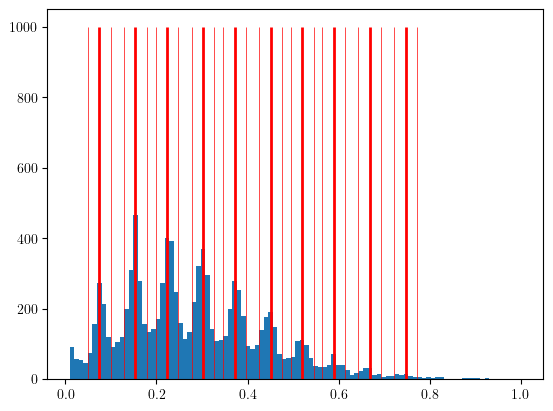

In [1732]:
sigma_e_b2, sigma_e_err_b2, time_res_b2 = resolution((0.01,1),
                                                     time_b2, waveforms_b2, 
                                                     baselines_b2, leds_b2, (5e-7, 6.e-7), (5e-7, 5.8e-7))

[0.08425 0.16345 0.23275 0.31195 0.38125 0.46045 0.52975 0.60895 0.67825
 0.74755 0.81685]


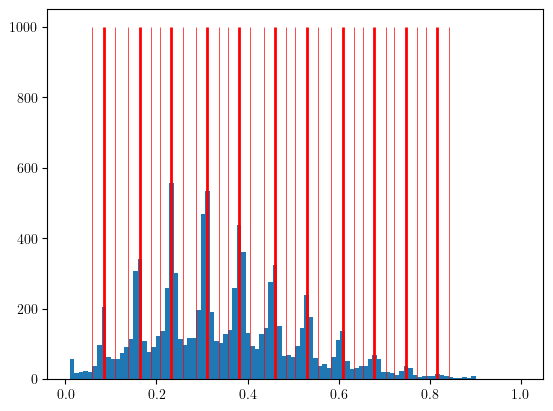

In [1728]:
sigma_e_sipm, sigma_e_err_sipm, time_res_sipm = resolution((0.01,1),time_sipm, waveforms_sipm, baselines_sipm, leds_sipm, (1.4e-7, 3e-7), (1.5e-7, 2.e-7))

[0.08425 0.15355 0.23275 0.30205 0.38125 0.45055 0.51985 0.57925 0.66835
 0.71785]


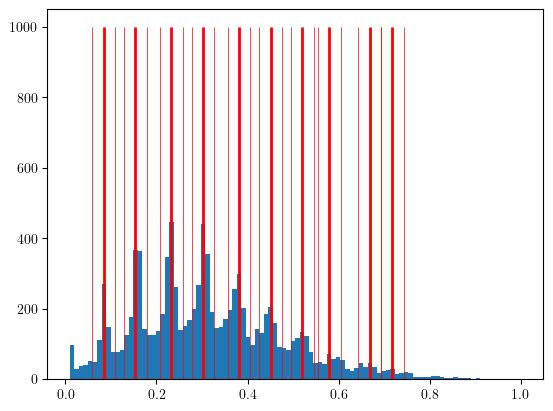

In [1719]:
sigma_e_y11, sigma_e_err_y11, time_res_y11 = resolution((0.01, 1), time_y11, waveforms_y11, baselines_y11, leds_y11, (1.4e-7, 3e-7), (1.5e-7, 2.5e-7))

In [1720]:
def time_res_fit(x, a, b, c):
    return np.sqrt((a/np.sqrt(x))**2 + (b/x)**2 + c**2)

In [1721]:
from scipy.optimize import curve_fit

In [1722]:
plt.rcParams.update({
    "font.family": "serif",
    "text.usetex": True
})

(0.5, 10.8)

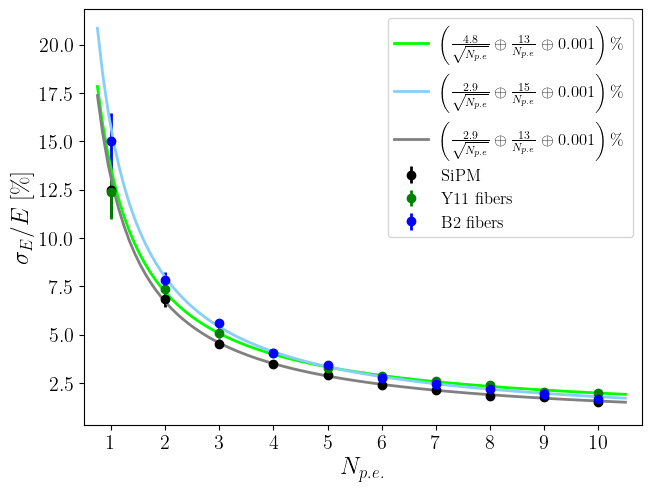

In [1743]:
fig, ax = plt.subplots(1,1,constrained_layout=True)
ax.errorbar(np.arange(len(sigma_e_sipm))+1, sigma_e_sipm, sigma_e_err_sipm, fmt='ko', label='SiPM')
ax.errorbar(np.arange(len(sigma_e_y11))+1, sigma_e_y11, sigma_e_err_y11, fmt='go', label='Y11 fibers')
ax.errorbar(np.arange(len(sigma_e_b2))+1, sigma_e_b2, sigma_e_err_b2, fmt='bo', label='B2 fibers')

xx = np.linspace(0.75,len(sigma_e_y11)+0.5,100)

popt, pcov = curve_fit(time_res_fit, np.arange(len(sigma_e_y11))+1, sigma_e_y11, sigma=sigma_e_err_y11, bounds=((0.,0,0.001), (100,100,100)))
ax.plot(xx, time_res_fit(xx, *popt), c='lime', label=r'$\left(\frac{%.2g}{\sqrt{N_{p.e}}} \oplus \frac{%.2g}{N_{p.e}} \oplus %.2g \right) \%%$' % tuple(popt))

popt, pcov = curve_fit(time_res_fit, np.arange(len(sigma_e_b2))+1, sigma_e_b2, sigma=sigma_e_err_b2, bounds=((0.,0,0.001), (100,100,100)))
ax.plot(xx, time_res_fit(xx, *popt), c='lightskyblue', label=r'$\left(\frac{%.2g}{\sqrt{N_{p.e}}} \oplus \frac{%.2g}{N_{p.e}} \oplus %.2g \right) \%%$' % tuple(popt))

popt, pcov = curve_fit(time_res_fit, np.arange(len(sigma_e_sipm))+1, sigma_e_sipm, sigma=sigma_e_err_sipm, bounds=((0.,0,0.001), (100,100,100)))
ax.plot(xx, time_res_fit(xx, *popt), c='gray', label=r'$\left(\frac{%.2g}{\sqrt{N_{p.e}}} \oplus \frac{%.2g}{N_{p.e}} \oplus %.2g \right) \%%$' % tuple(popt))

ax.set_xlabel("$N_{p.e.}$", fontsize='xx-large')
ax.set_ylabel("$\sigma_E/E$ [\%]", fontsize='xx-large')
ax.set_xticks(np.arange(1,len(sigma_e)+1))
ax.legend(fontsize='large')
ax.tick_params(axis='both', which='major', labelsize='x-large')
fig.savefig("energy_res.pdf")
ax.set_xlim(0.5,10.8)


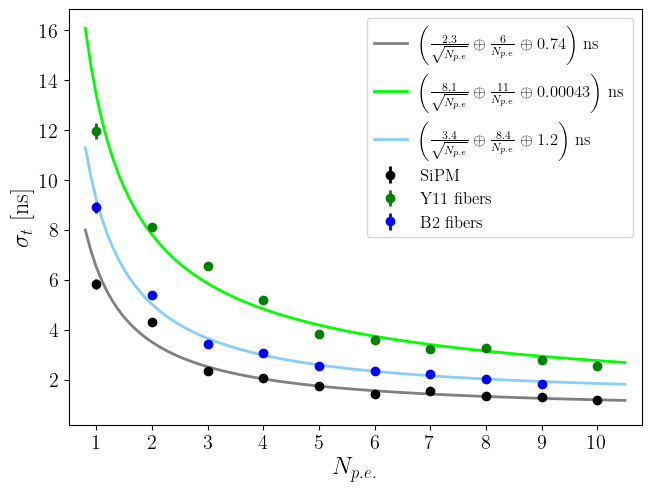

In [1740]:
fig, ax = plt.subplots(1,1,constrained_layout=True)

pes = np.array(list(time_res_y11.keys()))+1
sigma = []
sigma_err = []

for pe in time_res_y11:
    sigma.append(np.std(time_res_y11[pe])*1e9)
    sigma_err.append(np.std(time_res_y11[pe])/np.sqrt(2*(len(time_res_y11[pe])-1))*1e9)
    
pes_b2 = np.array(list(time_res_b2.keys())[:9])+1
sigma_b2 = []
sigma_err_b2 = []

for pe in list(time_res_b2.keys())[:9]:
    sigma_b2.append(np.std(time_res_b2[pe])*1e9)
    sigma_err_b2.append(np.std(time_res_b2[pe])/np.sqrt(2*(len(time_res_b2[pe])-1))*1e9)
    
pes_sipm = np.array(list(time_res_sipm.keys()))+1
sigma_sipm = []
sigma_err_sipm = []

for pe in list(time_res_sipm.keys()):
    sigma_sipm.append(np.std(time_res_sipm[pe])*1e9)
    sigma_err_sipm.append(np.std(time_res_sipm[pe])/np.sqrt(2*(len(time_res_sipm[pe])-1))*1e9)
    
    
popt, pcov = curve_fit(time_res_fit, pes_sipm, sigma_sipm, sigma=sigma_err_sipm, bounds=((0,0,0),(100, 100, 100)))
ax.plot(xx, time_res_fit(xx, *popt), c='gray', label=r'$\left(\frac{%.2g}{\sqrt{N_{p.e}}} \oplus \frac{%.2g}{N_{p.e}} \oplus %.2g \right)$ ns' % tuple(popt))
ax.errorbar(pes_sipm, sigma_sipm, sigma_err_sipm, fmt='ko', label='SiPM')

    
popt, pcov = curve_fit(time_res_fit, pes, sigma, sigma=sigma_err)
xx = np.linspace(0.8,len(sigma)+0.5,100)
ax.plot(xx, time_res_fit(xx, *popt), c='lime', label=r'$\left(\frac{%.2g}{\sqrt{N_{p.e}}} \oplus \frac{%.2g}{N_{p.e}} \oplus %.2g \right)$ ns' % tuple(popt))
ax.errorbar(pes, sigma, sigma_err, fmt='go', label='Y11 fibers')


popt, pcov = curve_fit(time_res_fit, pes_b2, sigma_b2, sigma=sigma_err_b2, bounds=((0,0,0),(100, 100, 100)))
ax.plot(xx, time_res_fit(xx, *popt), c='lightskyblue', label=r'$\left(\frac{%.2g}{\sqrt{N_{p.e}}} \oplus \frac{%.2g}{N_{p.e}} \oplus %.2g \right)$ ns' % tuple(popt))
ax.errorbar(pes_b2, sigma_b2, sigma_err_b2, fmt='bo', label='B2 fibers')


ax.set_xlabel("$N_{p.e.}$", fontsize='xx-large')
ax.set_ylabel("$\sigma_t$ [ns]", fontsize='xx-large')
ax.legend(fontsize='large')
ax.set_xticks(np.arange(1,len(sigma)+1))
ax.tick_params(axis='both', which='major', labelsize='x-large')
ax.set_xlim(0.5,10.8)
fig.savefig("time_res.pdf")


In [1500]:
np.sqrt(np.array(sigma)[:8]**2-np.array(sigma_sipm)**2)

array([7.23196643, 5.64550946, 4.72935556, 3.64280017, 3.58715098,
       3.28036689, 3.28110841, 2.71724927])

In [ ]:
def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))